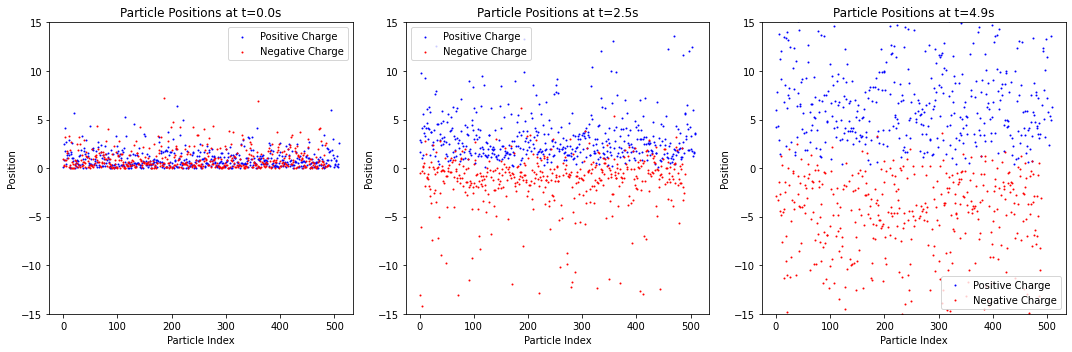

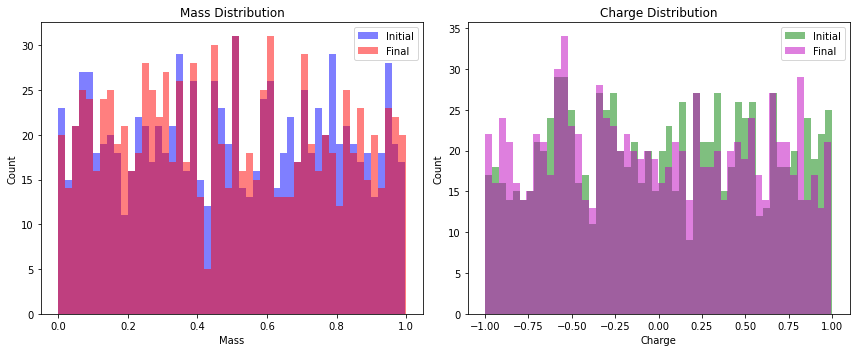

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the PDF and CDF
def pdf(x, k):
    return k * np.exp(-x)

def cdf(x, k):
    return 1 - np.exp(-k * x)

# Rejection Sampling for interaction positions
def rejection_sampling(pdf, cdf, k, num_samples):
    samples = []
    while len(samples) < num_samples:
        x = -np.log(1 - np.random.rand())  # Generate positions using the inverse transform sampling method
        u = np.random.rand()
        if u < pdf(x, k) / (k * cdf(x, k)):
            samples.append(x)
    return samples

# Particle Class
class Particle:
    def __init__(self):
        self.initial_mass = np.random.rand()          # Store initial mass
        self.initial_charge = np.random.uniform(-1, 1)  # Store initial charge
        self.mass = self.initial_mass
        self.charge = self.initial_charge
        self.position = -np.log(1 - np.random.rand())  # Using the inverse transform sampling method.
        self.velocity = 0                     # Initial velocity is set to 0.

    def acceleration(self, E):
        return self.charge * E / self.mass    # Acceleration due to electric field.

# Simulation Class
class Simulation:
    def __init__(self, num_particles=1000, E=0.5, dt=0.1, T=5, k=1.0):
        self.particles = [Particle() for _ in range(num_particles)]
        self.E = E
        self.dt = dt
        self.time_steps = int(T/dt)
        self.positions_odeint = []
        self.k = k

    def particle_ode(self, y, t, q, m, E):
        x, v = y
        dxdt = v
        dvdt = q * E / m
        return [dxdt, dvdt]

    def evolve(self):
        t = np.linspace(0, 5, self.time_steps)

        self.positions_odeint = [odeint(self.particle_ode, [p.position, p.velocity], t, args=(p.charge, p.mass, self.E))[:,0] for p in self.particles]

    def plot_positions(self):
        times_to_plot = [0, int(2.5/self.dt), int(5/self.dt) - 1]

        plt.figure(figsize=(15, 5))
        for i, time_idx in enumerate(times_to_plot):
            plt.subplot(1, 3, i+1)
            positions_at_time = [sol[time_idx] for sol in self.positions_odeint]
            charges = [p.charge for p in self.particles]

            # Separate positive and negative charges
            pos_positions = [pos for pos, charge in zip(positions_at_time, charges) if charge >= 0]
            neg_positions = [pos for pos, charge in zip(positions_at_time, charges) if charge < 0]

            plt.scatter(range(len(pos_positions)), pos_positions, s=1, color='b', label='Positive Charge')
            plt.scatter(range(len(neg_positions)), neg_positions, s=1, color='r', label='Negative Charge')

            plt.title(f"Particle Positions at t={time_idx*self.dt}s")
            plt.ylim(-15,15)
            plt.xlabel("Particle Index")
            plt.ylabel("Position")
            plt.legend()
            plt.tight_layout()

        plt.tight_layout()
        plt.savefig("ParticlePositions1.png")
        plt.show()


    def get_final_distributions(self):
        final_masses = [p.mass for p in self.particles]
        final_charges = [p.charge for p in self.particles]
        return final_masses, final_charges

    def get_initial_distributions(self):
        initial_masses = [p.initial_mass for p in self.particles]
        initial_charges = [p.initial_charge for p in self.particles]
        return initial_masses, initial_charges

    def perform_interactions(self):
        # Rejection Sampling to determine interaction positions
        interaction_positions = rejection_sampling(pdf, cdf, self.k, len(self.particles))

        # Define the interaction threshold (you can adjust this value)
        interaction_threshold = 0.5

        for particle, position in zip(self.particles, interaction_positions):
            if position < interaction_threshold:
                # If the particle's position is below the interaction threshold, update its characteristics
                particle.mass = np.random.rand()
                particle.charge = np.random.uniform(-1, 1)


if __name__ == "__main__":
    sim = Simulation(k=1.0)  # Pass the k value
    sim.evolve()
    sim.plot_positions()

    # Perform interactions and update particle characteristics
    sim.perform_interactions()

    # Get final mass and charge distributions
    final_masses, final_charges = sim.get_final_distributions()

    # Get initial mass and charge distributions
    initial_masses, initial_charges = sim.get_initial_distributions()

    # Plot histograms of the initial and final mass and charge distributions
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(initial_masses, bins=50, color='b', alpha=0.5, label='Initial')
    plt.hist(final_masses, bins=50, color='r', alpha=0.5, label='Final')
    plt.title('Mass Distribution')
    plt.xlabel('Mass')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(initial_charges, bins=50, color='g', alpha=0.5, label='Initial')
    plt.hist(final_charges, bins=50, color='m', alpha=0.5, label='Final')
    plt.title('Charge Distribution')
    plt.xlabel('Charge')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.savefig("MassChargeDistributions1.png")
    plt.show()
